# Problem 1 

In [1]:
from scipy.special import expit
import os
import gzip
import pickle
import wget
import random
import numpy as np
from scipy.special import softmax
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

import math

In [2]:
def plotThis(x, label ):
    xnew = np.linspace(np.arange(x.shape[0]).min(),np.arange(x.shape[0]).max(),300)
    spl = make_interp_spline(np.arange(x.shape[0]),x, k=3)
    power_smooth = spl(xnew)
    xx = plt.plot(xnew,power_smooth, label = label)

def vectorized_result(y):
    e = np.zeros((10, 1))
    e[y] = 1.0
    return e

def load_mnist():
    if not os.path.exists(os.path.join(os.curdir, 'data')):
        os.mkdir(os.path.join(os.curdir, 'data'))
        wget.download('http://deeplearning.net/data/mnist/mnist.pkl.gz', out='data')

    data_file = gzip.open(os.path.join(os.curdir, 'data', 'mnist.pkl.gz'), 'rb')
    training_data, validation_data, test_data = pickle.load(data_file, encoding='latin1')
    data_file.close()

    training_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in training_data[0]]))
    training_results = np.squeeze(np.asarray([vectorized_result(y) for y in training_data[1]]))

    validation_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in validation_data[0]]))
    validation_results = np.asarray(validation_data[1])
    
    test_inputs = np.squeeze(np.asarray([np.reshape(x, (784, 1)) for x in test_data[0]]))
    test_results = np.squeeze(np.asarray(test_data[1]))
    return training_inputs, training_results, validation_inputs, validation_results, test_inputs, test_results

training_inputs, training_results, validation_inputs, validation_results, test_inputs, test_results= load_mnist()

In [3]:
np.random.seed(5)
def softmaxx(z):
        return softmax(z, axis=1)

def sigmoid(z):
    return expit(z)

def sigmoid_prime(z):
    return z*(1-z)

def ReLU(z):
    return np.maximum(z, 0)

def ReLU_prime(x):
    return np.where(x > 0, 1.0, 0.0)

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x**2

    
class NN(object):
    def __init__(self, network_units, activation_fn, lr, batch_size, initialization):
        self.network_units = network_units
        if activation_fn =="ReLU":
            self.activation_fn = ReLU
            self.activation_p = ReLU_prime
        elif activation_fn == "sigmoid":
            self.activation_fn = sigmoid
            self.activation_p = sigmoid_prime
        elif activation_fn == "tanh":
            self.activation_fn = tanh
            self.activation_p = tanh_prime
        self.parameters = {}
        self.gradients = {}
        self.initialization = initialization
        self.initialize_weights()
        self.lr = lr
        self.batch_size = batch_size
    def initialize_weights(self):
        
        for i in range(len(self.network_units)-1):
            
            self.parameters["b"+str(i)] = np.zeros((self.network_units[i+1]))
            
            if self.initialization == "glorot":
                self.parameters["w"+str(i)] = np.random.uniform( 
                                -np.sqrt(6./(self.network_units[i]+self.network_units[i+1])), 
                                np.sqrt(6./(self.network_units[i]+self.network_units[i+1])),
                                size=(self.network_units[i],self.network_units[i+1])
                                                              )
            elif self.initialization == "normal":
                self.parameters["w"+str(i)] = np.random.normal(scale=1, size=(self.network_units[i],self.network_units[i+1]))
            
            elif self.initialization == "zero":
                self.parameters["w"+str(i)] = np.zeros(shape=(self.network_units[i],self.network_units[i+1]))
    
            self.gradients["b"+str(i)] = np.zeros((self.network_units[i+1]))
            self.gradients["w"+str(i)] = np.zeros((self.network_units[i], self.network_units[i+1]))

            
    def num_parameters(self):
        pars = 0.0
        for i in range(len(self.network_units)-1):
            pars += self.network_units[i]
            pars += (self.network_units[i] * self.network_units[i+1])
        print("we have ", pars/1000000, " million parameters")
    
    def forward(self, x):
        self.x = x
        self.h1 = self.activation_fn(np.dot(x, self.parameters["w0"]) + self.parameters["b0"])
        self.h2 = self.activation_fn(np.dot(self.h1, self.parameters["w1"]) + self.parameters["b1"])
        self.out = expit(np.dot(self.h2, self.parameters["w2"]) + self.parameters["b2"])
        return self.out
    
    def loss(self, y):
        self.y = y
        l = -y*np.log(self.out+1e-8)-(1-y)*np.log(1-self.out+1e-8)
        m_b_l = np.sum(l, axis=1)
        self.lossy = np.mean(m_b_l)
        return self.lossy
    
    def backward(self):
        
        
        dout = (-self.y/(self.out+1e-8)) + (1-self.y) * (1/(1-self.out+1e-8))
        del2 = self.out*(1-self.out)*dout
        doutdw2 = np.dot(self.h2.T, del2)/len(self.x)
        doutdb2 = np.mean(del2, axis=0)
        
        
        douth2 = np.dot(del2, self.parameters["w2"].T)
        del1 = self.activation_p(self.h2)*douth2
        doutdw1 = np.dot(self.h1.T, del1)/len(self.x)
        doutdb1 = np.mean(del1, axis=0)
        
        douth1 = np.dot(del1, self.parameters["w1"].T)
        del0 = self.activation_p(self.h1)*douth1
        doutdw0 = np.dot(self.x.T, del0)/len(self.x)
        doutdb0 = np.mean(del0, axis=0)
        
        self.gradients["w2"] = doutdw2
        self.gradients["b2"] = doutdb2
        self.gradients["w1"] = doutdw1
        self.gradients["b1"] = doutdb1
        self.gradients["w0"] = doutdw0
        self.gradients["b0"] = doutdb0
        
    def grad_check(self, single_training_example, single_training_result, p, row):
        output = self.forward(single_training_example)
        loss = self.loss(single_training_result)
        self.backward()
        all_Ns = []
        max_differences = []
        for k in range(1,5):
            for i in range(0,5):
                N = k * math.pow(10,i)
                all_Ns.append(N)
                
                epsilon = 1.0 / N

                #finite_difference:
                numerical_gradient = 0.0
                max_difference = 0
                for j in range(10):

                    analytic_gradient = self.gradients[p][row][j]
                    #left
                    self.parameters[p][row][j] += epsilon
                    self.forward(single_training_example)
                    left_loss = self.loss(single_training_result)
                    #right
                    self.parameters[p][row][j] -= (2 * epsilon)
                    self.forward(single_training_example)
                    right_loss = self.loss(single_training_result)
                    self.parameters[p][row][j] += epsilon
                    numerical_gradient = (left_loss - right_loss)/ (2*epsilon)
                    current_difference = np.abs(numerical_gradient - analytic_gradient)

                    if j==0 and k ==1 : ##so that we print less
                        print("\n analytic gradient: ", analytic_gradient)
                        print("\n numerical gradient: ", numerical_gradient)

                        print("\n difference: ",current_difference)
                    if current_difference > max_difference:
                        max_difference = current_difference
                max_differences.append(max_difference)
        return all_Ns, max_differences
        
                

    def update(self):
        for ind in ["w0", "w1", "w2", "b0", "b1", "b2"]:
            self.parameters[ind] -= self.lr * self.gradients[ind]
            

    def train(self,training_inputs, training_results, epochs, validation_inputs, validation_targets):
        loss = np.zeros((epochs))
        accuracy = np.zeros((epochs))
        for epoch in range(epochs):
            shuffle(training_inputs, training_results, random_state=0)
            mini_batches = [training_inputs[k:k+self.batch_size] for k in range(0, training_inputs.shape[0], self.batch_size)]
            mini_batches_results = [training_results[k:k+self.batch_size] for k in range(0, training_results.shape[0], self.batch_size)]
            #print(mini_batches_results[0])
            #break
            current_loss=0
            for mini_batch_index in range(len(mini_batches)):
                self.forward(mini_batches[mini_batch_index])
                current_loss += self.loss(mini_batches_results[mini_batch_index])
                self.backward()
                self.update()
            current_loss /= len(mini_batches)
            loss[epoch] = current_loss
            print("loss ", current_loss)
            currentAccuray = self.test(validation_inputs, validation_targets)
            accuracy[epoch] = currentAccuray
        return loss, accuracy 
    def test(self, validation_inputs, validation_targets):
        results = self.forward(validation_inputs)
        labels = np.argmax(results, axis=1)
        accuracy = np.sum(labels == validation_targets)/100
        print("validation accuracy", accuracy)
        return accuracy

## Part 1 --> Initilization:
For I ran the model with 32 as the mini batch size, 500 units for both hidden layers which makes the total number of parameters to be 0.648784 million. I used Tanh activation for the hidden layer non linearities. Learning rate was chosen to be 0.01.



In [4]:
myNet = NN([784,500, 500,10], "tanh", lr=0.01, batch_size=32, initialization="glorot")
glorot_tanh_loss, glorot_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  1.1164179979846724
validation accuracy 90.75
loss  0.6950673664685939
validation accuracy 91.95
loss  0.6050231667101836
validation accuracy 92.72
loss  0.5399757484267349
validation accuracy 93.49
loss  0.48513346678860914
validation accuracy 94.21
loss  0.4387914861264825
validation accuracy 94.78
loss  0.4000609361711175
validation accuracy 95.15
loss  0.36755883622510893
validation accuracy 95.48
loss  0.33990956481458173
validation accuracy 95.7
loss  0.3160346749069279
validation accuracy 95.93


In [5]:
myNet.num_parameters()

we have  0.648784  million parameters


In [6]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="normal")
normal_tanh_loss, normal_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  13.456949253401321
validation accuracy 63.16
loss  6.411948394495567
validation accuracy 78.13
loss  4.470102517770257
validation accuracy 82.31
loss  3.576102835561771
validation accuracy 84.11
loss  2.977552041005509
validation accuracy 85.77
loss  2.479080365328968
validation accuracy 86.38
loss  2.060742958451472
validation accuracy 86.8
loss  1.7424743135541088
validation accuracy 87.15
loss  1.5169863371930792
validation accuracy 87.33
loss  1.3475133218428337
validation accuracy 87.33


In [7]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="zero")
zero_tanh_loss, zero_tanh_accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)

loss  3.9038961822548104
validation accuracy 10.64
loss  3.263139512360626
validation accuracy 10.64
loss  3.2499328012046065
validation accuracy 10.64
loss  3.2492479667845178
validation accuracy 10.64
loss  3.2492051413143557
validation accuracy 10.64
loss  3.2492018641627025
validation accuracy 10.64
loss  3.249201468825749
validation accuracy 10.64
loss  3.2492013871150247
validation accuracy 10.64
loss  3.2492013652469045
validation accuracy 10.64
loss  3.249201359024071
validation accuracy 10.64


# Part 1.1:
Above we have shown the loss for every epoch for the three types of initilization. 

# Part 1.2:
The three plots for both losses and accuracies are plotted in the following:
When we have a symmetric(in this case zero initilization) initilization method, we know that the gradients for each of those weights will also be symmetric so all the updates would be same which is in essence equivalent to having only one neuron instead of 500.

When we have gaussian distribution then since we are breaking the symmetry we can learn better than symmetric ones like zero. Also since the standard deviation  is 1 which is large, it quickly saturates the gradients which will slow the learning. 

Using glorot gave the best accuracy and the main reason is possibly because we have neither the problem of gradient saturation nor symmetry. 

<IPython.core.display.Javascript object>


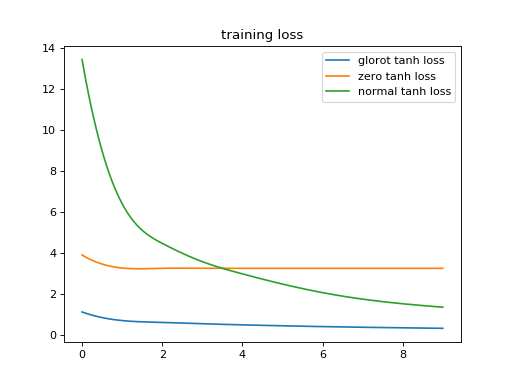

In [15]:
%matplotlib notebook
plotThis(glorot_tanh_loss, "glorot tanh loss")
plotThis(zero_tanh_loss, "zero tanh loss")
plotThis(normal_tanh_loss, "normal tanh loss")

plt.title("training loss")
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


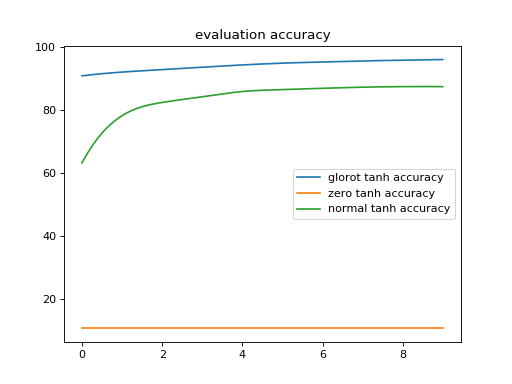

In [9]:
%matplotlib notebook
plotThis(glorot_tanh_accuracy, "glorot tanh accuracy")
plotThis(zero_tanh_accuracy, "zero tanh accuracy")
plotThis(normal_tanh_accuracy, "normal tanh accuracy")

plt.title("evaluation accuracy")
plt.legend()
plt.show()


## Part 2 
For the hyperparameter search, we test with the 450, 500, 550, 600, 650 as the architecture model. Both the hidden layers will have the same number of neurons. For the case of NonLinearity we will test with ReLU, sigmoid and tanh and for the learning rate we will try 0.001, 0.01, 0.1. I will test mini batch size for 32, 64, and 128.

In [10]:
architecture = [450, 500, 550, 600, 650]
non_linearity = ["ReLU", "sigmoid", "tanh"]
learning_rate = [0.001, 0.01, 0.1]
mini_batch_size = [32, 64, 128]
best_accuracy = 0
best_arch = None 
best_non_linearity = None
best_learning_rate = None
best_mini_batch_size = None
for i in range(len(architecture)):
    for j in range(len(non_linearity)):
        for k in range(len(learning_rate)):
            for l in range(len(mini_batch_size)):
                myNet = NN([784,architecture[i], architecture[i], 10], non_linearity[j], lr=learning_rate[k], batch_size=mini_batch_size[l], initialization="glorot")
                _ , accuracy = myNet.train(training_inputs, training_results, 10, validation_inputs, validation_results)
                if accuracy[-1] > best_accuracy:
                    best_accuracy = accuracy[-1]
                    best_arch = i 
                    best_non_linearity = j
                    best_learning_rate = k
                    best_mini_batch_size = l
print("we achieved best accuracy of ", best_accuracy, "with the following hyperparameters:\n ",
                          architecture[best_arch], " --> units for both hidden layers\n",
                          non_linearity[best_non_linearity], "--> the non Linearity chosen for the hidden layer activations\n",
                          learning_rate[best_learning_rate], "--> the learning rate\n", 
                          mini_batch_size[best_mini_batch_size], "--> the size of each mini batch\n"
                        
                          
                         )


loss  2.8215304269028905
validation accuracy 81.18
loss  1.6466354594256578
validation accuracy 85.96
loss  1.2259929093377568
validation accuracy 88.07
loss  1.0290546691347637
validation accuracy 89.37
loss  0.9111716063351294
validation accuracy 90.07
loss  0.8317430324166492
validation accuracy 90.55
loss  0.7738575859839024
validation accuracy 90.98
loss  0.7291727927848121
validation accuracy 91.23
loss  0.6931476341341364
validation accuracy 91.46
loss  0.6631200452769088
validation accuracy 91.73
loss  3.4481846103342093
validation accuracy 67.32
loss  2.4989205788551296
validation accuracy 77.29
loss  1.9502901942777147
validation accuracy 81.94
loss  1.5962483320567067
validation accuracy 84.57
loss  1.3778532315684129
validation accuracy 86.22
loss  1.2314938019591517
validation accuracy 87.23
loss  1.1258653700876262
validation accuracy 88.09
loss  1.0455616535827035
validation accuracy 88.83
loss  0.9821290270994817
validation accuracy 89.36
loss  0.9305205486518032
valida

loss  0.9741485445240117
validation accuracy 87.74
loss  0.7684790602335253
validation accuracy 89.88
loss  0.6799552756470086
validation accuracy 91.32
loss  0.6210740653854983
validation accuracy 92.05
loss  0.5747186705343852
validation accuracy 92.55
loss  0.5358900342667022
validation accuracy 93.03
loss  0.5025259091458572
validation accuracy 93.37
loss  0.47342878866087545
validation accuracy 93.75
loss  0.447767999675736
validation accuracy 94.06
loss  2.7043691320444148
validation accuracy 76.66
loss  1.4174651712308797
validation accuracy 86.54
loss  1.0367478117462972
validation accuracy 88.51
loss  0.8804366126710063
validation accuracy 89.45
loss  0.7949290149009692
validation accuracy 89.97
loss  0.7385307549430464
validation accuracy 90.42
loss  0.6960546604657712
validation accuracy 91.08
loss  0.661651038846923
validation accuracy 91.45
loss  0.6323270069678615
validation accuracy 91.79
loss  0.6063807206744439
validation accuracy 92.0
loss  2.349734487828619
validatio

loss  0.8103637025663607
validation accuracy 91.02
loss  0.700690520312556
validation accuracy 91.71
loss  0.6316938393771845
validation accuracy 92.38
loss  0.581766450905912
validation accuracy 92.79
loss  0.5426014441170035
validation accuracy 93.4
loss  0.5102887559544222
validation accuracy 93.75
loss  0.48281212924727224
validation accuracy 94.12
loss  0.4588895727104389
validation accuracy 94.47
loss  0.4865484270184574
validation accuracy 96.39
loss  0.1959497385814495
validation accuracy 97.33
loss  0.1302848731277189
validation accuracy 97.46
loss  0.0919671796590181
validation accuracy 97.67
loss  0.06561507947679449
validation accuracy 97.81
loss  0.04635120383839426
validation accuracy 98.06
loss  0.0324541320557197
validation accuracy 98.12
loss  0.022676704185578482
validation accuracy 98.14
loss  0.015799309110499548
validation accuracy 98.2
loss  0.011111686394226751
validation accuracy 98.17
loss  0.6494955198869443
validation accuracy 94.66
loss  0.27942840412101977


validation accuracy 93.46
loss  0.4857409286018926
validation accuracy 94.25
loss  0.4400055108627943
validation accuracy 94.72
loss  0.4017957572588396
validation accuracy 95.17
loss  0.369618314019521
validation accuracy 95.5
loss  0.3421504201427322
validation accuracy 95.81
loss  0.3183827573928293
validation accuracy 95.98
loss  1.3852444575188099
validation accuracy 89.83
loss  0.8240815286253131
validation accuracy 90.88
loss  0.717115661060665
validation accuracy 91.49
loss  0.6588718346976172
validation accuracy 92.06
loss  0.6159693702622793
validation accuracy 92.57
loss  0.5797955559174318
validation accuracy 92.9
loss  0.5474312872514724
validation accuracy 93.31
loss  0.517827815822915
validation accuracy 93.65
loss  0.4906203645748108
validation accuracy 93.95
loss  0.46566354663676035
validation accuracy 94.37
loss  1.7724115900392117
validation accuracy 87.43
loss  1.0421387322194124
validation accuracy 89.37
loss  0.8734183086434604
validation accuracy 90.36
loss  0.7

validation accuracy 39.01
loss  3.17941721820684
validation accuracy 43.27
loss  3.1660163735589486
validation accuracy 46.11
loss  3.152064210293728
validation accuracy 48.79
loss  3.1374569410944875
validation accuracy 50.91
loss  3.122085681560048
validation accuracy 53.07
loss  3.365586791776006
validation accuracy 10.69
loss  3.2392064827335525
validation accuracy 10.78
loss  3.233132858946801
validation accuracy 11.12
loss  3.227049384334254
validation accuracy 12.18
loss  3.2209436841730077
validation accuracy 14.47
loss  3.2148039528932926
validation accuracy 17.71
loss  3.208618429205094
validation accuracy 21.16
loss  3.2023753506714074
validation accuracy 24.52
loss  3.19606291197389
validation accuracy 28.37
loss  3.1896692252128593
validation accuracy 31.79
loss  3.1245430528954836
validation accuracy 62.04
loss  2.49970979753958
validation accuracy 76.8
loss  1.790399091284238
validation accuracy 82.7
loss  1.4201913506034638
validation accuracy 85.49
loss  1.209794074223

loss  0.23657889996125817
validation accuracy 96.84
loss  0.2114655897943706
validation accuracy 97.01
loss  0.1908812947331795
validation accuracy 97.21
loss  0.17355578691366386
validation accuracy 97.29
loss  2.842015629700195
validation accuracy 80.24
loss  1.6745691638547842
validation accuracy 85.39
loss  1.249882176898763
validation accuracy 87.81
loss  1.0465905424500843
validation accuracy 89.14
loss  0.923665837016678
validation accuracy 90.0
loss  0.8412025788572686
validation accuracy 90.65
loss  0.781857625668771
validation accuracy 91.05
loss  0.7365529515485134
validation accuracy 91.5
loss  0.7002758471561298
validation accuracy 91.82
loss  0.6701820055573667
validation accuracy 92.01
loss  3.311922651462681
validation accuracy 70.93
loss  2.3929748070414534
validation accuracy 78.97
loss  1.860225149052577
validation accuracy 83.15
loss  1.525474159357491
validation accuracy 85.39
loss  1.320117933312872
validation accuracy 86.77
loss  1.1826047848125756
validation acc

validation accuracy 95.12
loss  0.3407673591216349
validation accuracy 95.38
loss  0.3164321568384954
validation accuracy 95.7
loss  2.0886195410069512
validation accuracy 79.72
loss  0.9779508926252408
validation accuracy 86.24
loss  0.7872190758823913
validation accuracy 89.47
loss  0.699732695980072
validation accuracy 90.85
loss  0.6407851561084589
validation accuracy 91.64
loss  0.5938759998670093
validation accuracy 92.22
loss  0.5543340562290103
validation accuracy 92.58
loss  0.5204417493298623
validation accuracy 93.04
loss  0.49104688143613595
validation accuracy 93.33
loss  0.46521615479679235
validation accuracy 93.7
loss  2.6983285950604152
validation accuracy 75.7
loss  1.414616669645578
validation accuracy 86.48
loss  1.0390124926052717
validation accuracy 88.53
loss  0.8836945443947383
validation accuracy 89.41
loss  0.80002832380833
validation accuracy 89.75
loss  0.7459527119190622
validation accuracy 90.27
loss  0.7059996407541812
validation accuracy 90.86
loss  0.67

validation accuracy 95.66
loss  0.31852627601681105
validation accuracy 95.86
loss  2.1182235577661928
validation accuracy 87.18
loss  1.0310468854463115
validation accuracy 89.92
loss  0.8055434198560639
validation accuracy 90.97
loss  0.6990393602520306
validation accuracy 91.82
loss  0.6319054766769775
validation accuracy 92.36
loss  0.5829813313968477
validation accuracy 92.74
loss  0.5444829383143366
validation accuracy 93.04
loss  0.5127269679753222
validation accuracy 93.36
loss  0.4856614665578832
validation accuracy 93.73
loss  0.4620546182769829
validation accuracy 94.04
loss  0.4858214604292492
validation accuracy 96.25
loss  0.19457316614198072
validation accuracy 96.97
loss  0.12751155339536915
validation accuracy 97.5
loss  0.08888801658212173
validation accuracy 97.73
loss  0.06245137523111994
validation accuracy 97.94
loss  0.04325475780148253
validation accuracy 98.03
loss  0.029950533020428636
validation accuracy 98.11
loss  0.020456276588590123
validation accuracy 98

loss  1.086621941817622
validation accuracy 90.84
loss  0.6919774588110256
validation accuracy 92.09
loss  0.6070638545156042
validation accuracy 92.77
loss  0.5436910873784458
validation accuracy 93.48
loss  0.4891624209796311
validation accuracy 94.36
loss  0.4427305317916051
validation accuracy 94.83
loss  0.40386424992076103
validation accuracy 95.15
loss  0.3712075175780891
validation accuracy 95.6
loss  0.3433534724641853
validation accuracy 95.73
loss  0.31921322025362614
validation accuracy 95.98
loss  1.3515380649339532
validation accuracy 89.84
loss  0.8176407637667813
validation accuracy 91.16
loss  0.7187192490018892
validation accuracy 91.78
loss  0.6653167264534878
validation accuracy 92.18
loss  0.6257120087994421
validation accuracy 92.52
loss  0.591665659758787
validation accuracy 92.8
loss  0.5604583627518132
validation accuracy 93.11
loss  0.531263831646258
validation accuracy 93.39
loss  0.5039559503988738
validation accuracy 93.78
loss  0.47859258531140375
validati

We achieved best accuracy of  98.22 with the following hyperparameters:<br>
                  550    -->      units for both hidden layers<br>
                  ReLU   -->      the non Linearity chosen for the hidden layer activations<br>
                  0.1    -->      the learning rate<br>
                  32     -->      the size of each mini batch<br>


## Part 3

In the following we perform gradient checking for different 

In [11]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="glorot")

myNet.grad_check(np.asarray([training_inputs[0]]), training_results[0], "w0", 0);


 analytic gradient:  -0.0

 numerical gradient:  0.0

 difference:  0.0

 analytic gradient:  -0.0

 numerical gradient:  0.0

 difference:  0.0

 analytic gradient:  -0.0

 numerical gradient:  0.0

 difference:  0.0

 analytic gradient:  -0.0

 numerical gradient:  0.0

 difference:  0.0

 analytic gradient:  -0.0

 numerical gradient:  0.0

 difference:  0.0


As you can see above all the gradients are zero for the first ten elements(the very first 10 elements of the 1st row) so the difference does not have a real meaning. It will be zero because corner of the image is all black which means all zero in the corner so the weights are going to end up at zero too. However, in the following you can see the gradient not being zero for the 161st row because the input corresponding to this weight is not zero. 


In [12]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="glorot")

myNet.grad_check(np.asarray([training_inputs[0]]), training_results[0], "w0", 161);



 analytic gradient:  0.024239615063063553

 numerical gradient:  0.020079873096401357

 difference:  0.004159741966662196

 analytic gradient:  0.024239615063063553

 numerical gradient:  0.024192859898275465

 difference:  4.6755164788088444e-05

 analytic gradient:  0.024239615063063553

 numerical gradient:  0.024239147260418648

 difference:  4.678026449059236e-07

 analytic gradient:  0.024239615063063553

 numerical gradient:  0.02423961038466871

 difference:  4.6783948451367685e-09

 analytic gradient:  0.024239615063063553

 numerical gradient:  0.024239615017407345

 difference:  4.56562079809153e-11


In [13]:
myNet = NN([784,500,500,10], "tanh", lr=0.01, batch_size=32, initialization="glorot")
N, max_differences = myNet.grad_check(np.asarray([training_inputs[0]]), training_results[0], "w1", 0);



 analytic gradient:  -0.038125702875859306

 numerical gradient:  -0.036975692372427815

 difference:  0.0011500105034314909

 analytic gradient:  -0.038125702875859306

 numerical gradient:  -0.03811377561120377

 difference:  1.1927264655535452e-05

 analytic gradient:  -0.038125702875859306

 numerical gradient:  -0.03812558355891227

 difference:  1.19316947037873e-07

 analytic gradient:  -0.038125702875859306

 numerical gradient:  -0.03812570168282292

 difference:  1.1930363849610437e-09

 analytic gradient:  -0.038125702875859306

 numerical gradient:  -0.038125702865876576

 difference:  9.982729920476885e-12


As shown above I tried for the second layer weights and you can properly see that the gradient checking is getting done appropriately. Since the second layers gives me more accurate gradient difference between the numerical and analytic gradient I will plot that only against N:



<IPython.core.display.Javascript object>


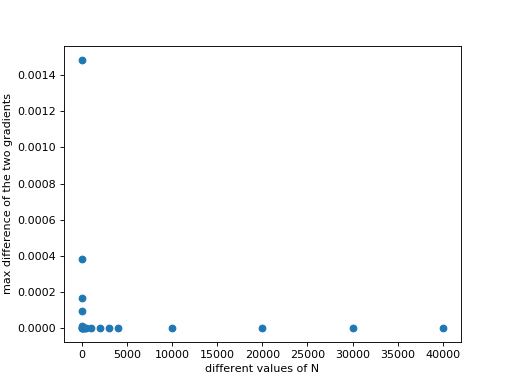

In [14]:

fig, ax = plt.subplots()
ax.plot(N, max_differences, 'o')
plt.ylabel("max difference of the two gradients")
plt.xlabel("different values of N")
plt.show()


The above plot shows that for very low values of N which makes epsilon large it is not good at all. But the larger values of N which make epsilon smaller gives us a more accurate gradient checking. 